In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import sys
sys.path.insert(0, '/home/xhding/workspaces/torch-deep-retina')
import os
import scipy
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyret
from kinetic.evaluation import *
from kinetic.utils import *
from kinetic.config import get_custom_cfg
from kinetic.data import *
from kinetic.notebook.functions import *
import kinetic.models as models

In [3]:
with h5py.File('/home/xhding/tem_stim/20-09-15/fullfield_whitenoise.h5', 'r') as f:
    stimulus =  np.asarray(f['test']['stimulus'][:, 25, 25]).astype('float32')
    resp = np.asarray(f['test']['response']['firing_rate_10ms'])

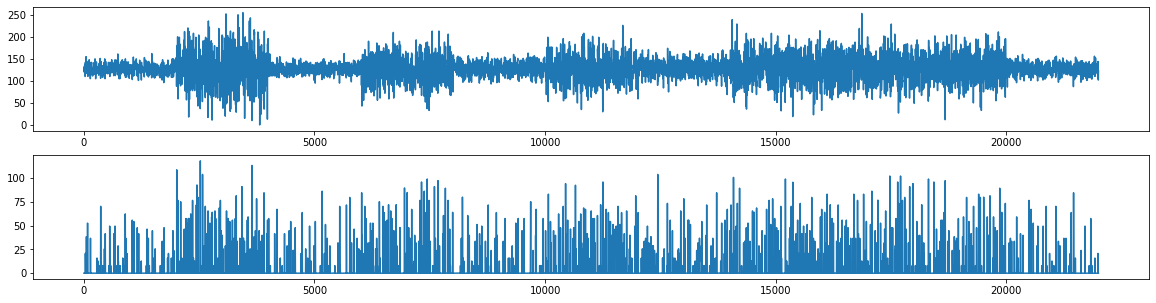

In [4]:
fig,ax = plt.subplots(2,1,figsize=(20,5))
ax[0].plot(stimulus)
ax[1].plot(resp)

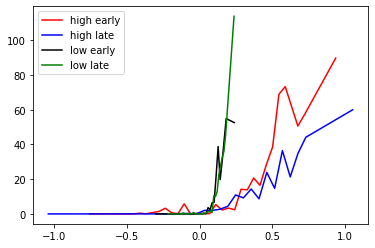

In [44]:
he, hl, le, ll = contrast_adaption_nonlinear(stimulus, resp[1], h_start=2000, l_start=4000, e_start=0)

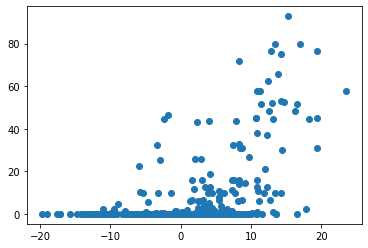

In [223]:
plt.plot(filtered_stim[filter_len:], resp_he[filter_len:], 'o')

In [6]:
device = torch.device('cuda:3')
cfg = get_custom_cfg('LNK')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/LNK/epoch_045_loss_1.21_pearson_0.6026.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
checkpoint['model_state_dict']['kinetics.ka'].data = checkpoint['model_state_dict']['kinetics.ka'].view(1, 1)
checkpoint['model_state_dict']['kinetics.kfi'].data = checkpoint['model_state_dict']['kinetics.kfi'].view(1, 1)
checkpoint['model_state_dict']['kinetics.kfr'].data = checkpoint['model_state_dict']['kinetics.kfr'].view(1, 1)
checkpoint['model_state_dict']['kinetics.ksi'].data = checkpoint['model_state_dict']['kinetics.ksi'].view(1, 1)
checkpoint['model_state_dict']['kinetics.ksr'].data = checkpoint['model_state_dict']['kinetics.ksr'].view(1, 1)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

LNK(
  (ln_filter): Temperal_Filter()
  (nonlinear): Sigmoid()
  (kinetics): Kinetics()
  (scale_shift): Linear(in_features=2, out_features=1, bias=True)
  (spiking): Softplus(beta=1, threshold=20)
)

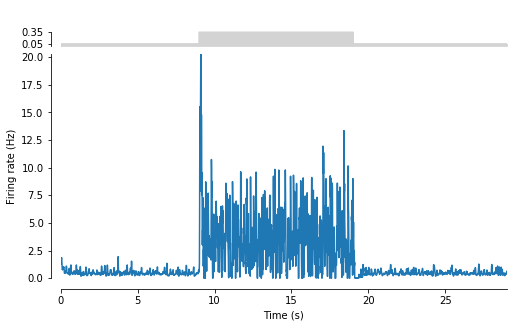

In [10]:
_, layer_outs = contrast_adaptation_kinetic(model, device, insp_keys=['nonlinear', 'kinetics'], hs_type='single', stim_type='one_pixel', filt_depth=100)

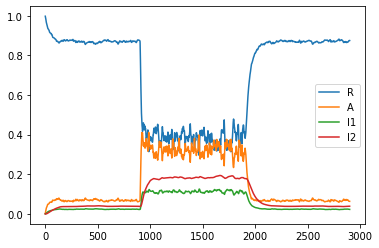

In [14]:
plt.plot(np.arange(2900),layer_outs['kinetics'][:, 0], label='R')
plt.plot(np.arange(2900),layer_outs['kinetics'][:, 1], label='A')
plt.plot(np.arange(2900),layer_outs['kinetics'][:, 2], label='I1')
plt.plot(np.arange(2900),layer_outs['kinetics'][:, 3], label='I2')
plt.legend()

In [4]:
test_data =  DataLoader(TestDatasetOnePixel(cfg, TrainDataset(cfg).stats), batch_size=1)
test_pc, pred, _ = pearsonr_eval_LNK_with_responses(model, test_data, device)
pred = np.pad(pred[:, 0], (100, 0), 'constant', constant_values=(0,0))

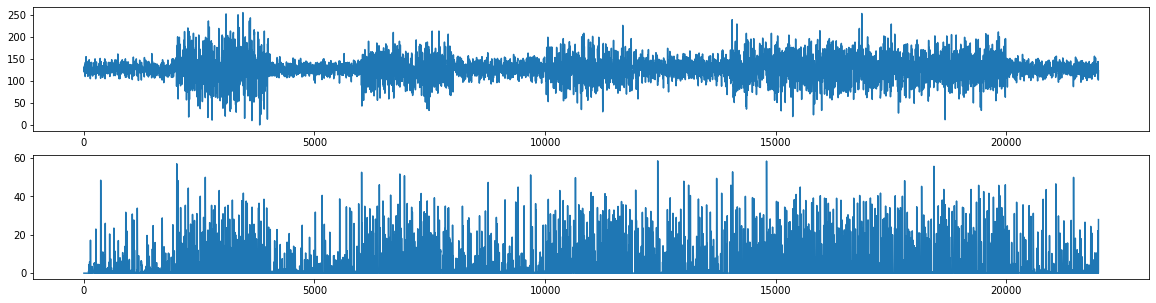

In [19]:
fig,ax = plt.subplots(2,1,figsize=(20,5))
ax[0].plot(stimulus)
ax[1].plot(pred)

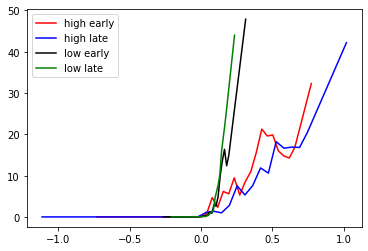

In [7]:
he, hl, le, ll = contrast_adaption_nonlinear(stimulus, pred, h_start=2000, l_start=4000)

In [3]:
device = torch.device('cuda:3')
cfg = get_custom_cfg('channel_filter_both')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/channel_filter_both/epoch_020_loss_-65.15_pearson_natural_0.4804_pearson_noise_0.6849.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

KineticsChannelModelFilterBipolarNoNorm(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): GaussianNoise(std=0.0, trainable=False, adapt=False, momentum=0.95)
    (2): Sigmoid()
    (3): Reshape(shape=(-1, 8, 1296))
  )
  (kinetics): Kinetics_channel()
  (amacrine): Sequential(
    (0): Reshape(shape=(-1, 8, 8, 36, 36))
    (1): Temperal_Filter()
    (2): LinearStackedConv2d(
      bias=True, abs_bnorm=False


In [4]:
cfg.Data.stim = 'naturalscene'
test_data =  DataLoader(TestDataset(cfg, TrainDataset(cfg).stats), batch_size=1)
test_pc = pearsonr_eval(model, test_data, 3, device)
test_pc

0.6039212140747764

In [5]:
device = torch.device('cuda:3')
cfg = get_custom_cfg('channel_filter_LNK')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/channel_filter_LNK_NoNorm_NoScale/epoch_010_loss_-63.69_pearson_0.4839.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data =  DataLoader(TestDataset(cfg, TrainDataset(cfg).stats), batch_size=1)
test_pc = pearsonr_eval(model, test_data, 3, device)
test_pc

0.6133493549203332

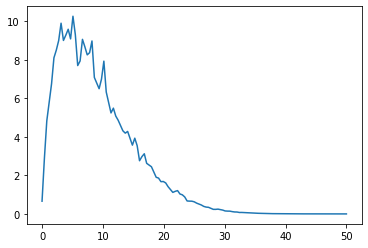

In [40]:
freq, power = scipy.signal.welch(resp, fs=100)
plt.plot(freq, power)

In [42]:
power.sum()/2

158.57023742634337

In [52]:
power[:21].sum()

163.00503990441658

7.039087454877219

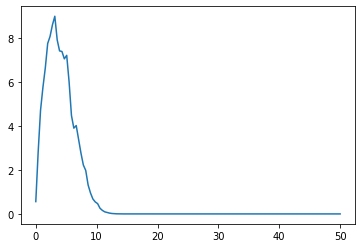

In [70]:
lp_filter = signal.firwin(25, 8, pass_zero='lowpass', fs=100)
freq, power = scipy.signal.welch(np.convolve(resp, lp_filter, 'valid'), fs=100)
plt.plot(freq, power)
np.convolve(resp, lp_filter, 'valid').std()

7.0064340246501775

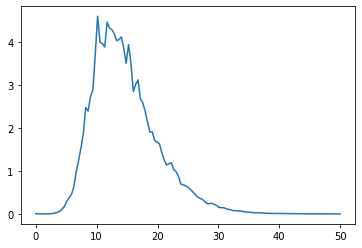

In [71]:
lp_filter = signal.firwin(25, 8, pass_zero='highpass', fs=100)
freq, power = scipy.signal.welch(np.convolve(resp, lp_filter, 'valid'), fs=100)
plt.plot(freq, power)
np.convolve(resp, lp_filter, 'valid').std()

In [85]:
torch.tensor(resp)[None, None,:].repeat(5,3,1).shape

torch.Size([5, 3, 22002])

In [86]:
y_targ = torch.tensor(resp)[None, None,:].repeat(5,3,1).to(device)
num_units = 3
numtaps = 25
f = 8
fs = 100
conv_filters = {}
for pass_zero in ['lowpass', 'highpass']:
    lp_filter = signal.firwin(numtaps, f, pass_zero=pass_zero, fs=fs)
    conv_filter = torch.nn.Conv1d(num_units, num_units, numtaps, groups=num_units, bias=False)
    conv_filter.weight.data = torch.from_numpy(np.flip(lp_filter).copy())[None, None, :].repeat(num_units, 1, 1)
    conv_filter.weight.requires_grad = False
    conv_filter = conv_filter.to(device)
    conv_filters[pass_zero] = conv_filter

y_targ_low = conv_filters['lowpass'](y_targ)
y_targ_high = conv_filters['highpass'](y_targ)

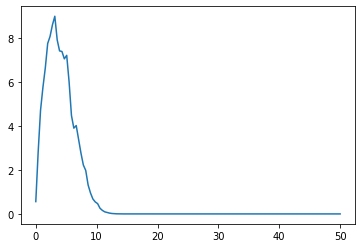

In [89]:
freq, power = scipy.signal.welch(y_targ_low.detach().cpu().numpy()[4,2,:], fs=100)
plt.plot(freq, power)

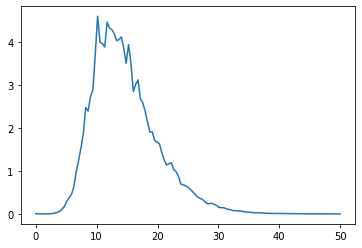

In [82]:
freq, power = scipy.signal.welch(y_targ_high.detach().cpu().numpy()[0,0,:], fs=100)
plt.plot(freq, power)

train one pixel model only for slow parameters

In [195]:
device = torch.device('cuda:3')
cfg = get_custom_cfg('one_pixel_norm_slow')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/one_pixel_channel/epoch_045_loss_1.01_pearson_0.7028.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

KineticsOnePixelChannel(
  (kinetics): Kinetics_channel()
  (amacrine_filter): Temperal_Filter()
  (ganglion): Sequential(
    (0): Linear(in_features=8, out_features=3, bias=False)
    (1): Softplus(beta=1, threshold=20)
  )
)

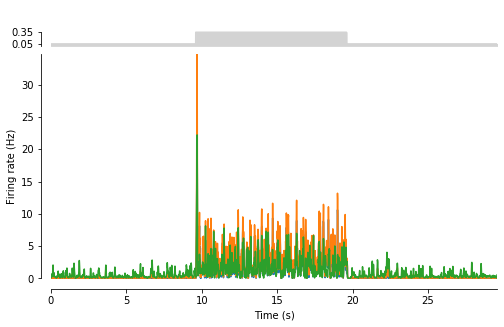

In [196]:
Rs, As, I1s, I2s, us, after_filters, after_amacrines = contrast_adaptation_onepixel_inspect(model, device, c0=0.05, c1=0.35, duration=1000, delay=1000, nsamples=3000, n_repeats=10)

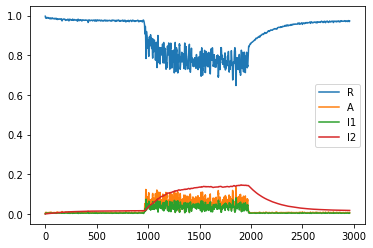

In [197]:
channel = 1
plt.plot(np.arange(2960),Rs[:,channel], label='R')
plt.plot(np.arange(2960),As[:,channel], label='A')
plt.plot(np.arange(2960),I1s[:,channel], label='I1')
plt.plot(np.arange(2960),I2s[:,channel], label='I2')
plt.legend()

In [198]:
test_data =  DataLoader(TestDatasetOnePixel(cfg, TrainDataset(cfg).stats), batch_size=1)
test_pc, pred, _ = pearsonr_eval_with_responses(model, test_data, 3, device)
pred = np.pad(pred, ((40, 0), (0,0)), 'constant', constant_values=(0,0))

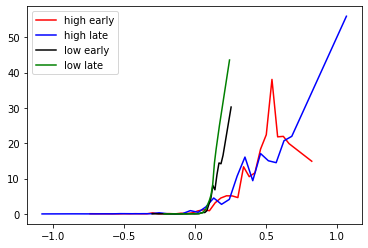

In [217]:
he, hl, le, ll = contrast_adaption_nonlinear(stimulus, pred[:, 0], h_start=2000, l_start=4000)

In [200]:
test_pc

0.7995286943563756

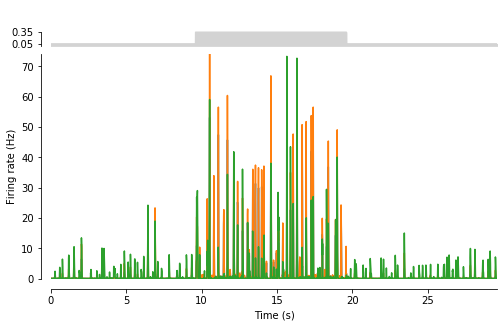

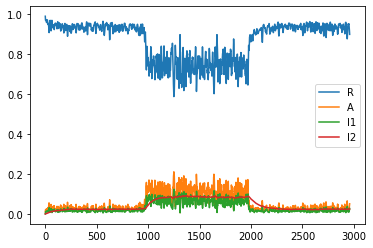

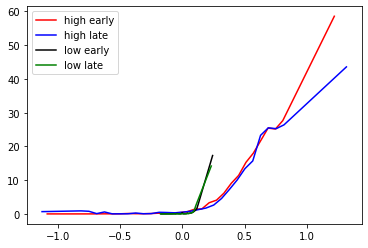

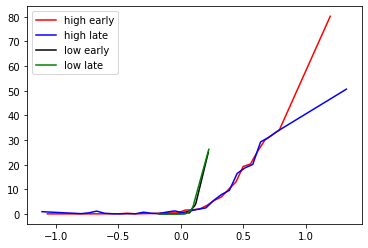

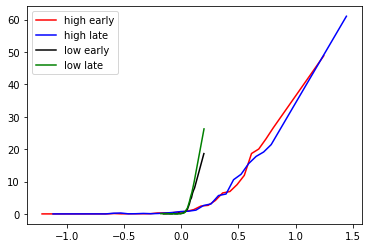

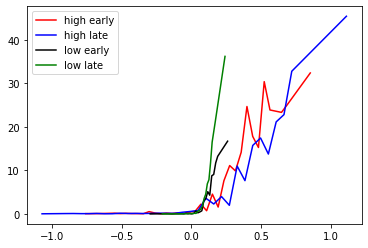

white noise prediction correlation :0.7853
natural scene prediction correlation: 0.6796


In [18]:
device = torch.device('cuda:3')
cfg_name = 'kinetics_both'
checkpoint_path = '/home/xhding/archived_models/kinetics/full.pth'
checkpoint_path_one_pixel = '/home/xhding/archived_models/kinetics/one_pixel.pth'
_, _, _ = analyze(cfg_name, checkpoint_path, checkpoint_path_one_pixel, stimulus, device)

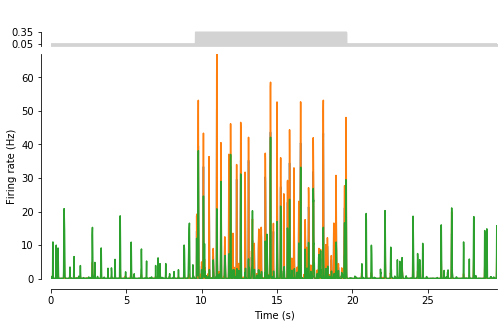

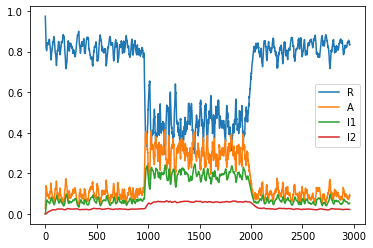

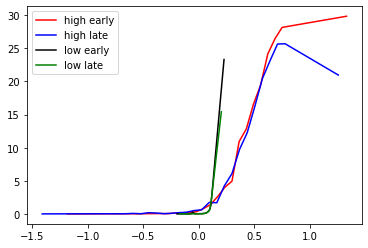

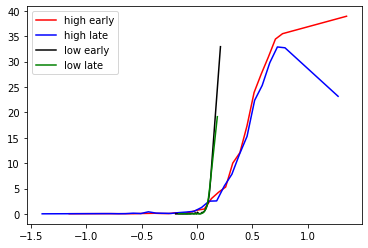

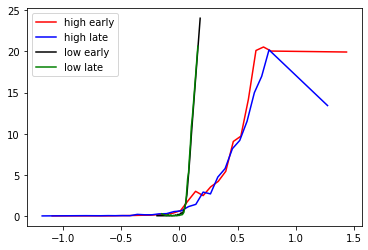

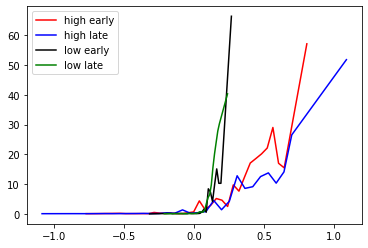

white noise prediction correlation :0.7988
natural scene prediction correlation: 0.6361


In [19]:
device = torch.device('cuda:3')
cfg_name = 'kinetics_both_LNKparam'
checkpoint_path = '/home/xhding/archived_models/kinetics_LNKparam/full.pth'
checkpoint_path_one_pixel = '/home/xhding/archived_models/kinetics_LNKparam/one_pixel.pth'
_, _, _ = analyze(cfg_name, checkpoint_path, checkpoint_path_one_pixel, stimulus, device)

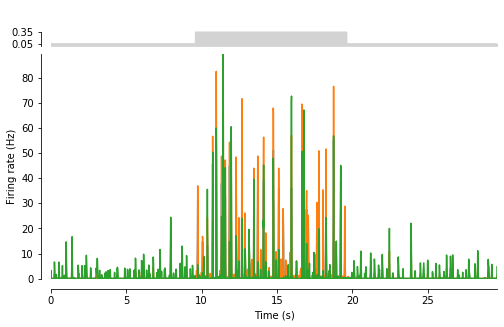

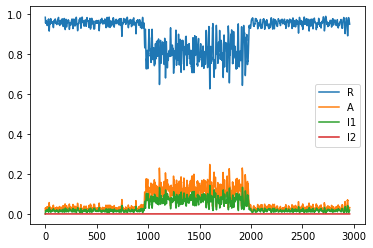

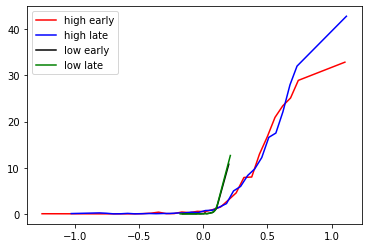

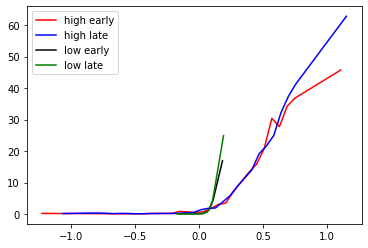

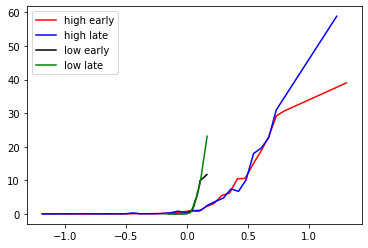

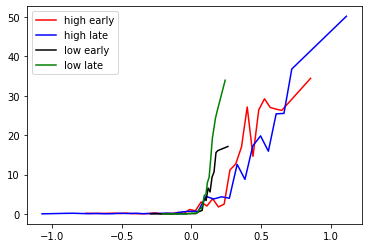

white noise prediction correlation :0.7863
natural scene prediction correlation: 0.6804


In [20]:
device = torch.device('cuda:3')
cfg_name = 'kinetics_both'
checkpoint_path = '/home/xhding/archived_models/kinetics/full.pth'
checkpoint_path_one_pixel = ''
_, _, _ = analyze(cfg_name, checkpoint_path, checkpoint_path_one_pixel, stimulus, device)

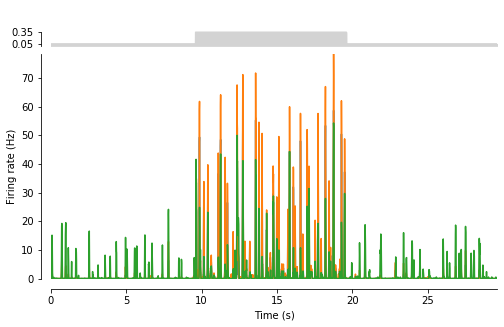

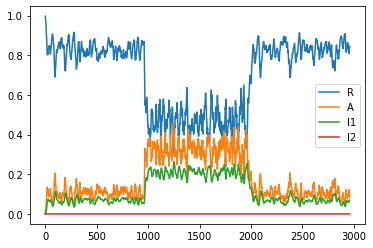

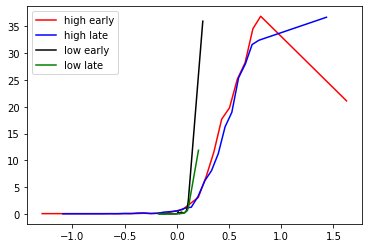

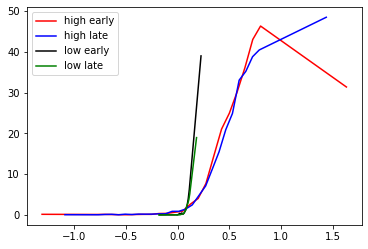

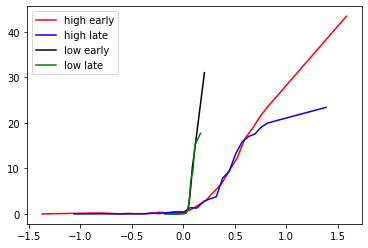

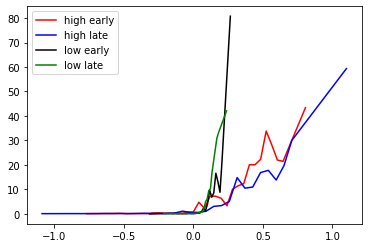

white noise prediction correlation :0.7963
natural scene prediction correlation: 0.6386


In [21]:
device = torch.device('cuda:3')
cfg_name = 'kinetics_both'
checkpoint_path = '/home/xhding/archived_models/kinetics_LNKparam/full.pth'
checkpoint_path_one_pixel = ''
_, _, _ = analyze(cfg_name, checkpoint_path, checkpoint_path_one_pixel, stimulus, device)

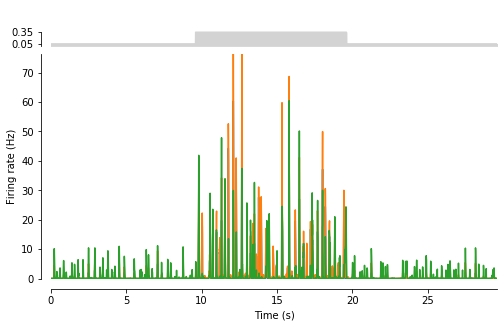

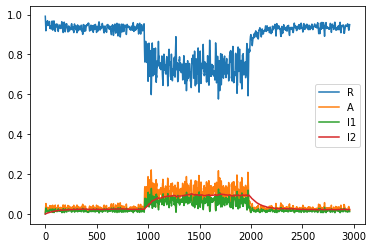

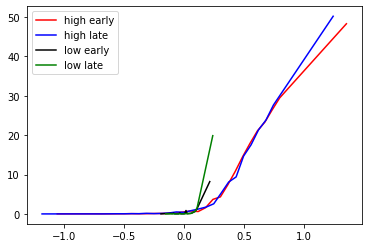

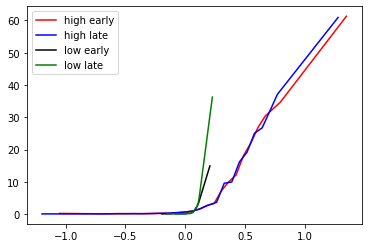

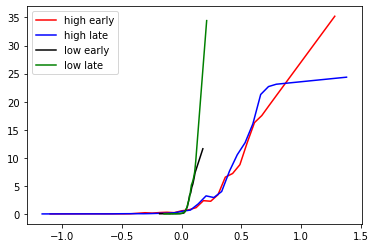

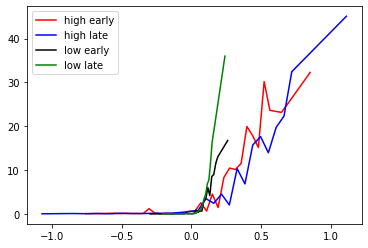

white noise prediction correlation :0.7848
natural scene prediction correlation: 0.6797


In [22]:
device = torch.device('cuda:3')
cfg_name = 'kinetics_both'
checkpoint_path = '/home/xhding/archived_models/kinetics/full.pth'
checkpoint_path_one_pixel = '/home/xhding/saved_model/kinetics_one_pixel_ksrgain/epoch_000_loss_1.03_pearson_0.7094.pth'
_, _, _ = analyze(cfg_name, checkpoint_path, checkpoint_path_one_pixel, stimulus, device)

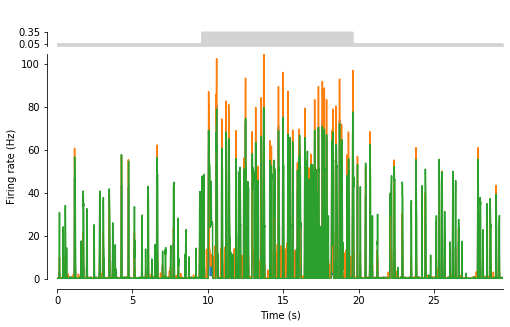

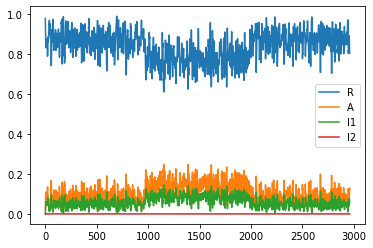

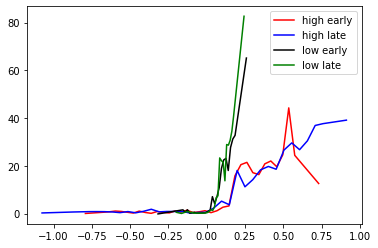

white noise prediction correlation :0.4543
natural scene prediction correlation: 0.6203


In [59]:
device = torch.device('cuda:3')
cfg_name = 'kinetics'
checkpoint_path = '/home/xhding/saved_model/kinetics/epoch_010_loss_-65.18_pearson_0.4982.pth'
checkpoint_path_one_pixel = ''
_, _, _ = analyze(cfg_name, checkpoint_path, checkpoint_path_one_pixel, stimulus, device)

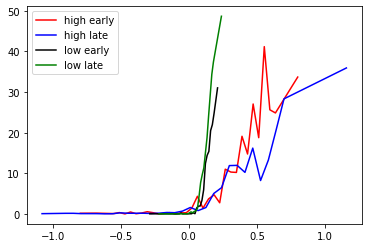

In [4]:
device = torch.device('cuda:3')
cfg = get_custom_cfg('kinetics_old')
checkpoint_path = '/home/xhding/saved_model/kinetics_old_both/epoch_015_loss_-64.86_pearson_natural_0.4970_pearson_noise_0.7111.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model_func = getattr(models, cfg.Model.name)
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
data_kwargs = dict(cfg.Data)
data_kwargs['stim'] = 'fullfield_whitenoise'
train_dataset_noise = MyDataset(stim_sec='train', **data_kwargs)
test_data_noise =  DataLoader(dataset=MyDataset(stim_sec='test', stats=train_dataset_noise.stats, **data_kwargs))
test_pc_noise, pred_noise, _ = pearsonr_eval(model, test_data_noise, 3, device, hs_mode='multiple', with_responses=True)
pred_noise = np.pad(pred_noise, ((40, 0), (0,0)), 'constant', constant_values=(0,0))
he, hl, le, ll = contrast_adaption_nonlinear(stimulus, pred_noise[:, 0], 2000, 4000)

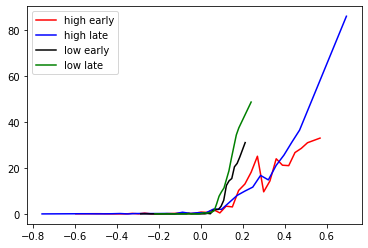

In [23]:
he, hl, le, ll = contrast_adaption_nonlinear(stimulus, pred_noise[:, 0], 6000, 4000, e_start=0)

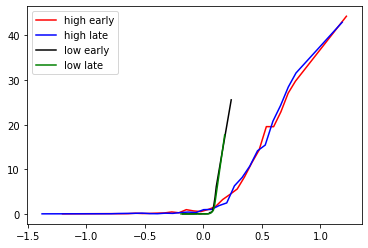

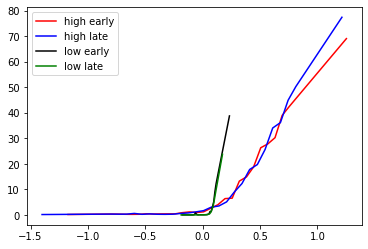

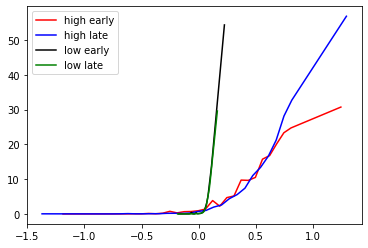

In [14]:
contrast_adaptation_LN(model, device, hs_mode='multiple', stim_type='full', cells=[0, 1, 2])